In [1]:
import pandas as pd
import numpy as np
import spacy
from spacy import displacy
import matplotlib.pyplot as plt
import networkx as nx

In [2]:
nlp = spacy.load("en_core_web_sm")

## Load the books and read into nlp

In [3]:
import os

# Scan directory and load books
books_load = [book for book in os.scandir("/kaggle/input/witcher/data") if ".txt" in book.name]

In [4]:
# Confirm that the books are loaded correctly
books_load

[<DirEntry 'B - The Sword of Destiny.txt'>,
 <DirEntry 'I - Blood of Elves.txt'>,
 <DirEntry 'C - The Last Wish.txt'>,
 <DirEntry 'II - Times of Contempt.txt'>,
 <DirEntry 'V - The Lady of the Lake.txt'>,
 <DirEntry 'IV - The Tower of the Swallow.txt'>,
 <DirEntry 'III - Baptism of Fire.txt'>,
 <DirEntry 'E - something ends something begins.txt'>]

In [5]:
# Read the books and load into nlp
book = books_load[1]
text = open(book).read()
doc = nlp(text)

In [6]:
# Visualize the named entities
displacy.render(doc[0:2000], style="ent", jupyter=True)

# Load character names

In [7]:
characters_df = pd.read_csv("/kaggle/input/witcher/characters.csv")

In [8]:
characters_df

,Unnamed: 0,book,character,first_name
0,0,Baptism of Fire,Adalia,Adalia
1,1,Baptism of Fire,Adela,Adela
2,2,Baptism of Fire,Aen Saevherne,Aen
3,3,Baptism of Fire,Aevenien,Aevenien
4,4,Baptism of Fire,Aglaïs,Aglaïs
...,...,...,...,...
1270,1270,Time of Contempt,Yanna of Murivel,Yanna
1271,1271,Time of Contempt,Yarpen Zigrin,Yarpen
1272,1272,Time of Contempt,Yennefer of Vengerberg,Yennefer
1273,1273,Time of Contempt,Yiolenta Suarez,Yiolenta


# Create lists of named entities for each sentence

In [9]:
sentence_entity_df = []

# Loop through sentences to store named entities
for sentence in doc.sents:
    entity_list = [ent.text for ent in sentence.ents]
    sentence_entity_df.append({'sentence': sentence, 'entities': entity_list})

# Convert list to dataframe and display
sentence_entity_df = pd.DataFrame(sentence_entity_df)
sentence_entity_df

,sentence,entities
0,"(﻿Verily, I, say, unto, you, ,, the, era, of, ...",[wolf]
1,"(The, Time, \n, of, the, White, Chill, and, th...","[Time, the White Chill, the White Light, the T..."
2,"(The, world, will, die, amidst, frost, and, be...",[]
3,"(It, will, be, reborn, of, the, Elder, Blood, ...","[the Elder Blood, Hen Ichaer]"
4,"(A, seed, which, \n, will, not, sprout, but, w...",[]
...,...,...
10646,"(Do, n't, let, anyone, harm, her, ., ', \n)",[]
10647,"(', I, 'll, be, back, ,, Mother, ,, ', said, C...","[Mother, Ciri]"
10648,"(Til, be, back, for, sure, !)",[]
10649,"(Soon, !, ', \n)",[]


In [10]:
# Function to filter out the non-character entities from the dataframe
def filter_entity(ent_list, characters_df):
    return [ent for ent in ent_list
            if ent in list(characters_df.character)
            or ent in list(characters_df.first_name)]

In [11]:
# Apply above function to  clean entity dataframe of non-character entities
sentence_entity_df['character_entities'] = sentence_entity_df['entities'].apply(lambda x: filter_entity(x, characters_df))

# Remove empty entity lists
sentence_entity_df = sentence_entity_df[sentence_entity_df['character_entities'].map(len) > 0]
sentence_entity_df

,sentence,entities,character_entities
8,"(What, signs, these, shall, be, ,, I, say, unt...","[first, earth, Aen Seidhe, the Blood of Elves,...",[Aevenien]
14,"(Ciri, felt, the, knight, who, carried, her, b...",[Ciri],[Ciri]
18,"(Ciri, caught, a, glimpse, of, the, skirmish, ...",[Ciri],[Ciri]
64,"(Ciri, sees, his, eyes, gleaming, through, the...","[Ciri, prey]",[Ciri]
67,"(Ciri, is, unable, to, move, .)",[Ciri],[Ciri]
...,...,...,...
10635,"(Take, care, of, her, ,, Yennefer, .)",[Yennefer],[Yennefer]
10639,"(Nenneke, did, not, look, at, \n, them, ., \n)",[Nenneke],[Nenneke]
10642,"(It, might, turn, out, to, be, true, ,, what, ...","[Ithlinne, Aevenien]","[Ithlinne, Aevenien]"
10645,"(Take, care, of, her, ,, Yennefer, .)",[Yennefer],[Yennefer]


In [12]:
# Convert character entities to only being the first name of the characters
sentence_entity_df['character_entities'] = sentence_entity_df['character_entities'].apply(lambda x: [item.split()[0]
                                                                                                     for item in x])
sentence_entity_df

/tmp/ipykernel_32/2789273216.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sentence_entity_df['character_entities'] = sentence_entity_df['character_entities'].apply(lambda x: [item.split()[0]


,sentence,entities,character_entities
8,"(What, signs, these, shall, be, ,, I, say, unt...","[first, earth, Aen Seidhe, the Blood of Elves,...",[Aevenien]
14,"(Ciri, felt, the, knight, who, carried, her, b...",[Ciri],[Ciri]
18,"(Ciri, caught, a, glimpse, of, the, skirmish, ...",[Ciri],[Ciri]
64,"(Ciri, sees, his, eyes, gleaming, through, the...","[Ciri, prey]",[Ciri]
67,"(Ciri, is, unable, to, move, .)",[Ciri],[Ciri]
...,...,...,...
10635,"(Take, care, of, her, ,, Yennefer, .)",[Yennefer],[Yennefer]
10639,"(Nenneke, did, not, look, at, \n, them, ., \n)",[Nenneke],[Nenneke]
10642,"(It, might, turn, out, to, be, true, ,, what, ...","[Ithlinne, Aevenien]","[Ithlinne, Aevenien]"
10645,"(Take, care, of, her, ,, Yennefer, .)",[Yennefer],[Yennefer]


# Create dataframe of relationships between characters

In [13]:
# Window size for sentences in which we will accept for a relationship to form
window_size = 5

# Create relationships list
relationships = []

# Loop through windows
for i in range(sentence_entity_df.index[-1]):
    end_i = min(i+5, sentence_entity_df.index[-1])
    character_list = sum((sentence_entity_df.loc[i: end_i].character_entities), [])
    
    # Remove any duplicates
    unique_characters = [character_list[i] for i in range(len(character_list))
                         if (i==0) or character_list[i] != character_list[i-1]]
    
    # When more than 1 character in window append to relationships list
    if len(unique_characters) > 1:
        for idx, x in enumerate(unique_characters[:-1]):
            y = unique_characters[idx + 1]
            relationships.append({'source': x, 'target': y})

# Convert list to dataframe
relationships_df = pd.DataFrame(relationships)
relationships_df

,source,target
0,Ciri,Geralt
1,Ciri,Geralt
2,Ciri,Geralt
3,Ciri,Geralt
4,Geralt,Yennefer
...,...,...
3777,Aevenien,Yennefer
3778,Yennefer,Ciri
3779,Yennefer,Ciri
3780,Yennefer,Ciri


In [14]:
# Sort the relationships
relationships_df = pd.DataFrame(np.sort(relationships_df.values, axis=1), columns = relationships_df.columns)
relationships_df

,source,target
0,Ciri,Geralt
1,Ciri,Geralt
2,Ciri,Geralt
3,Ciri,Geralt
4,Geralt,Yennefer
...,...,...
3777,Aevenien,Yennefer
3778,Ciri,Yennefer
3779,Ciri,Yennefer
3780,Ciri,Yennefer


In [15]:
# Create column for weighting relationships
relationships_df['weight'] = 1
# Aggregate relationships and weight them
relationships_df = relationships_df.groupby(['source','target'], sort=False, as_index=False).sum()
relationships_df

,source,target,weight
0,Ciri,Geralt,297
1,Geralt,Yennefer,128
2,Cirilla,Yennefer,5
3,Cirilla,Dandelion,4
4,Donimir,Sheldon,5
...,...,...,...
208,Aine,Ciri,4
209,Lambert,Yennefer,5
210,Ithlinne,Nenneke,3
211,Aevenien,Ithlinne,6


# Graph visualization

In [19]:
# Create a graph from a pandas dataframe
G = nx.from_pandas_edgelist(relationships_df, 
                            source = "source", 
                            target = "target", 
                            edge_attr = "weight", 
                            create_using = nx.Graph())

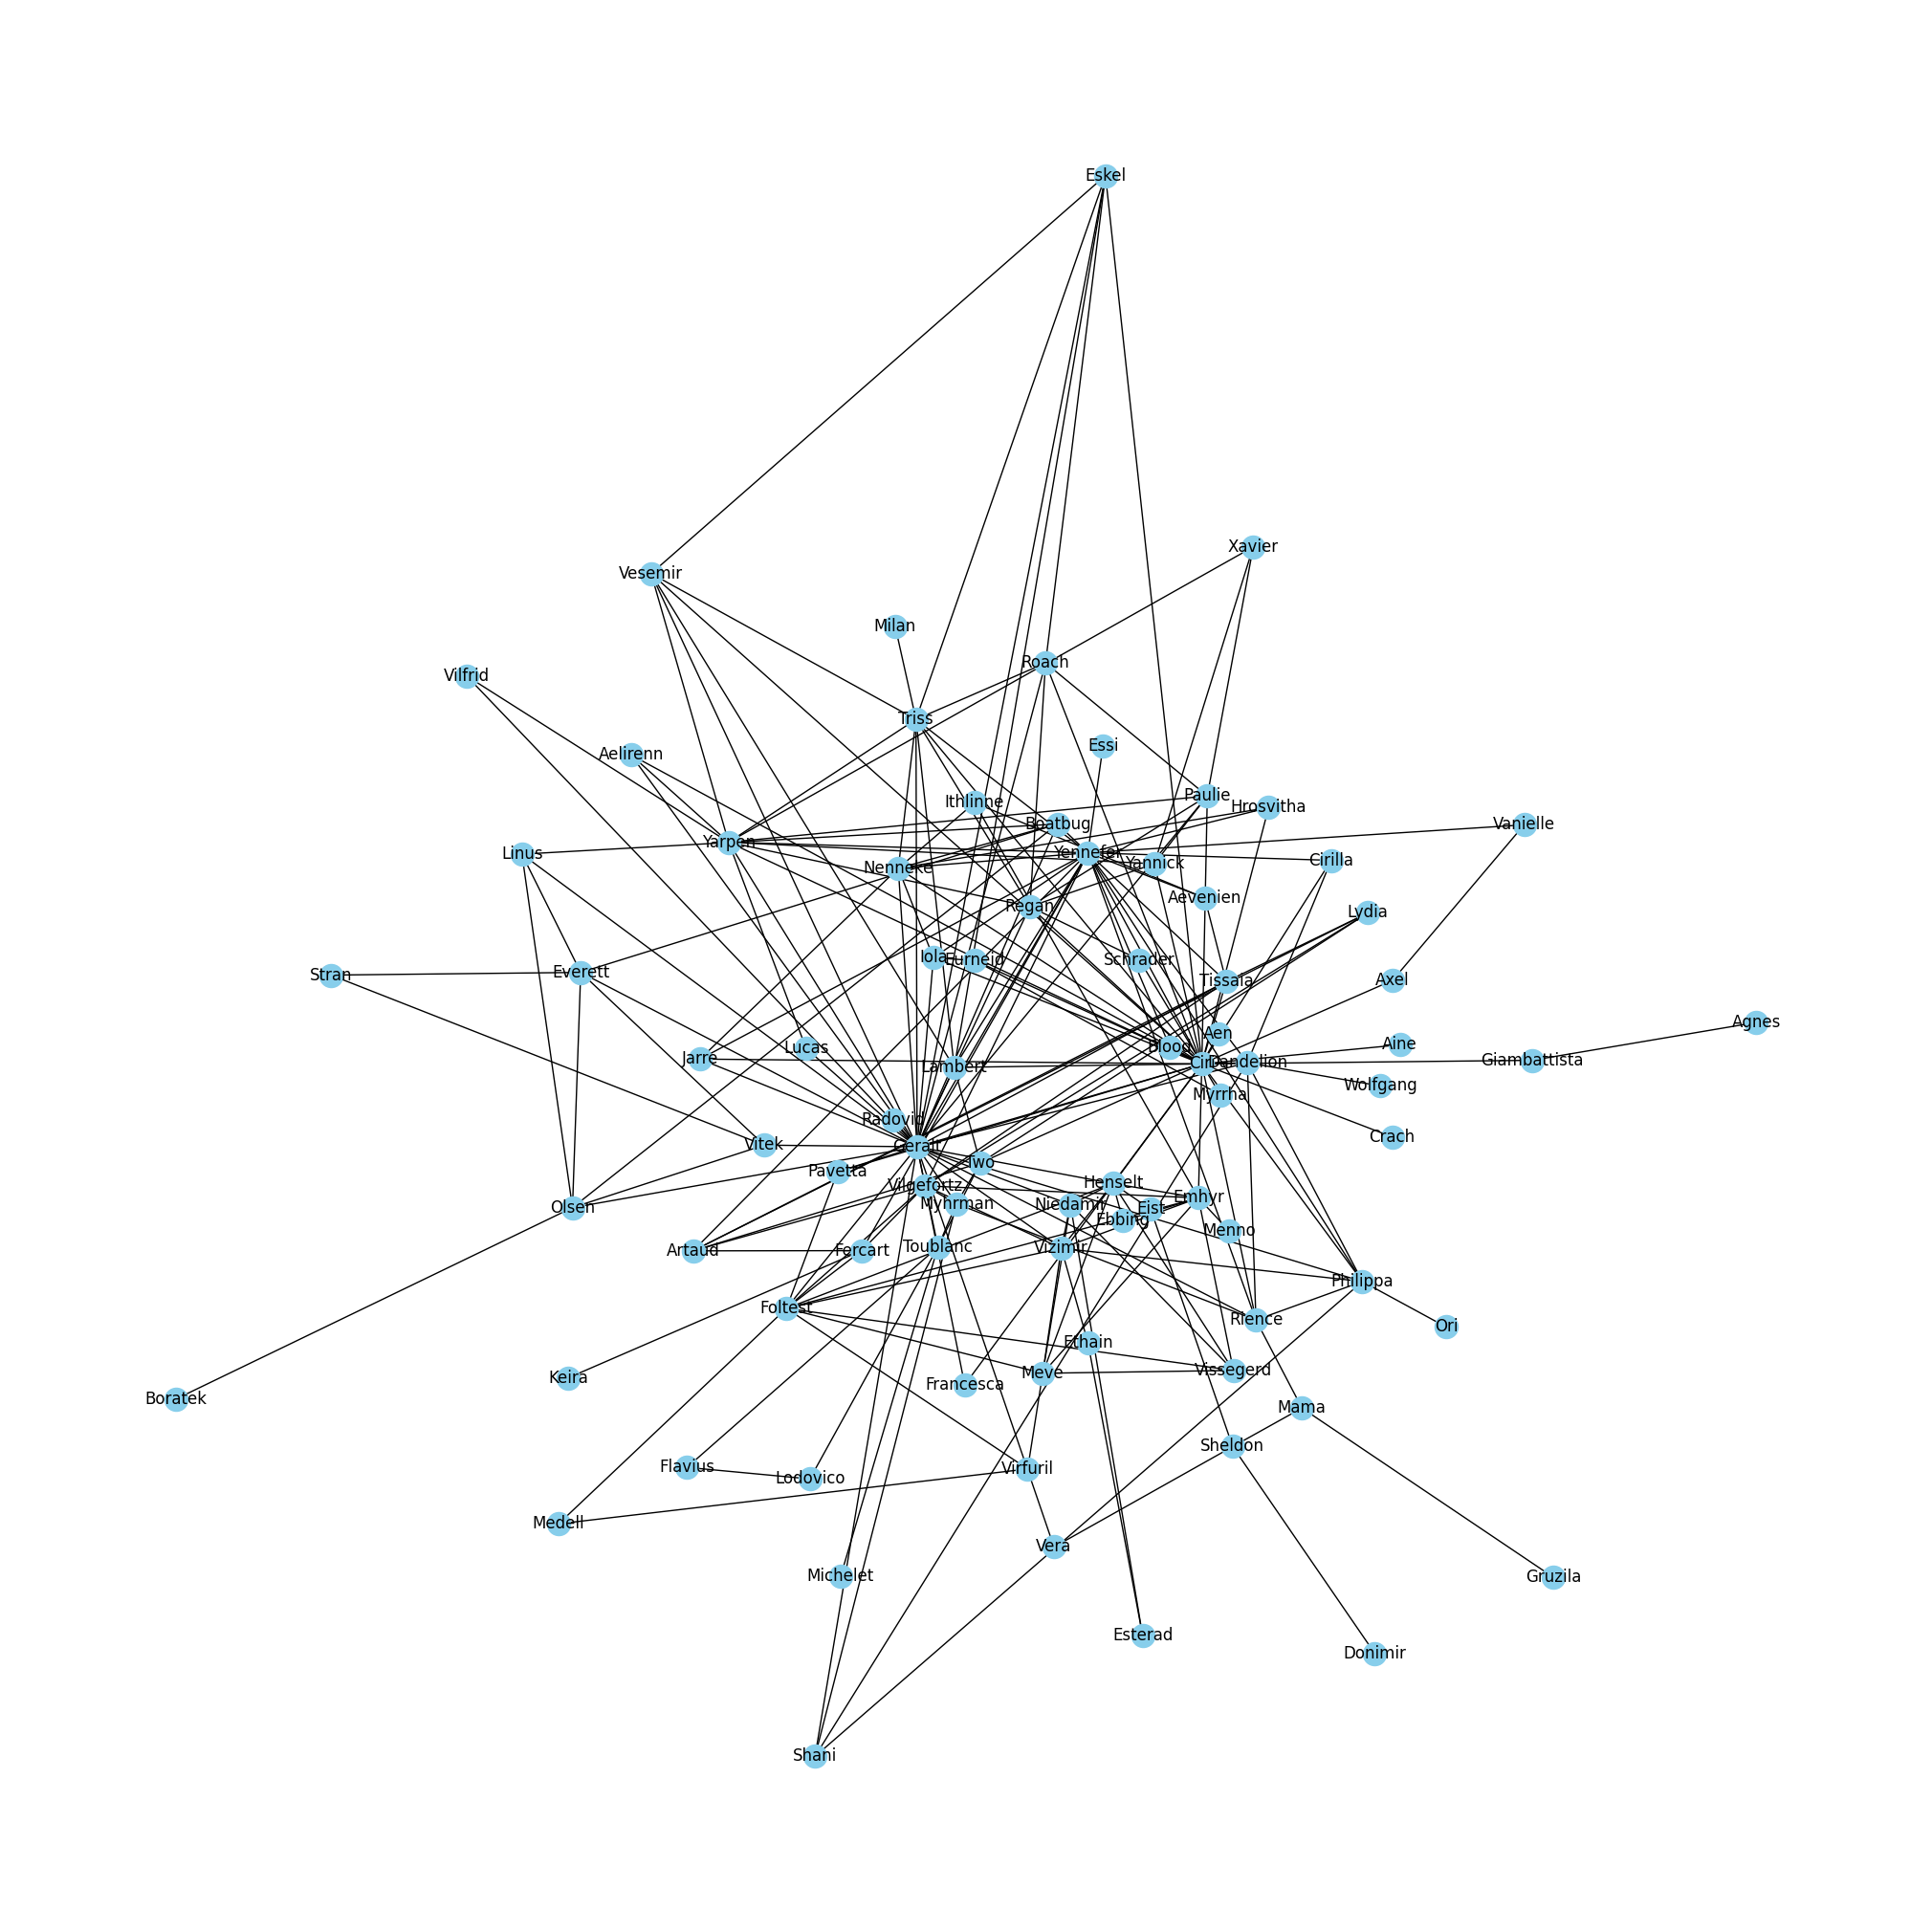

In [21]:
plt.figure(figsize=(20,20))
pos = nx.kamada_kawai_layout(G)
nx.draw(G, with_labels=True, node_color='skyblue', edge_cmap=plt.cm.Blues, pos = pos)
plt.show()